In [5]:
# Phishing Email Detection Using TF-IDF + SVM and Fine-tuned DistilBERT

# 1. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import re
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
import torch

import kagglehub
from kagglehub import KaggleDatasetAdapter

In [6]:
# 2. Load Dataset
# Dataset: phishing_email.csv from Kaggle

# Set the path to the file you'd like to load
file_path = "phishing_email.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "naserabdullahalam/phishing-email-dataset",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

# Rename columns to match expected names
df.rename(columns={'text_combined': 'body', 'label': 'label'}, inplace=True)

# Set the variable 'data' with 'df'
data = df

print("First 5 records:", data.head())

<ipython-input-6-ee2de80c207b>:8: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


First 5 records:                                                 body  label
0  hpl nom may 25 2001 see attached file hplno 52...      0
1  nom actual vols 24 th forwarded sabrae zajac h...      0
2  enron actuals march 30 april 1 201 estimated a...      0
3  hpl nom may 30 2001 see attached file hplno 53...      0
4  hpl nom june 1 2001 see attached file hplno 60...      0


In [7]:
# 3. Preprocessing - Improved

# Remove missing values first
data.dropna(subset=['body', 'label'], inplace=True)

# Define text cleaning function
def clean_email_body(text):
    text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub(r'\S+@\S+', '', text)  # Remove email addresses
    text = re.sub(r'http\S+', '', text)   # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetic characters
    text = text.lower()  # Lowercase
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

# Apply cleaning
data['body'] = data['body'].apply(clean_email_body)

# Remove very short emails
data = data[data['body'].str.len() > 20]

# Sample 10,000 rows after cleaning
# data = data.sample(n=20000, random_state=42)

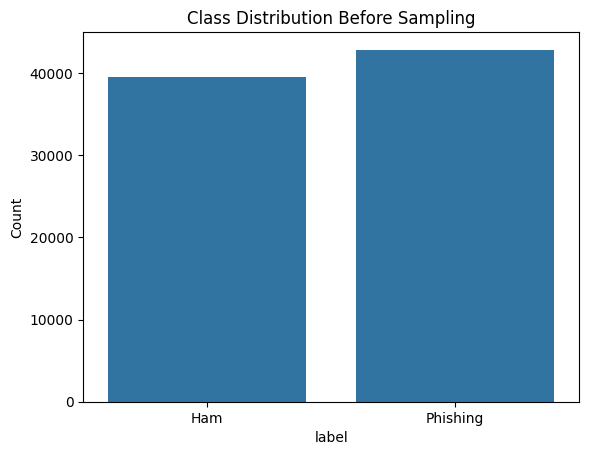

In [8]:
# Visualize label distribution
label_counts = data['label'].value_counts()
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("Class Distribution Before Sampling")
plt.xticks([0, 1], ['Ham', 'Phishing'])
plt.ylabel("Count")
plt.savefig("label_distribution_before_sampling.png")
plt.show()

In [9]:
# # Sample 20,000 rows while maintaining class balance
# from sklearn.utils import resample

# data_ham = data[data['label'] == 0]
# data_phish = data[data['label'] == 1]

# n_ham = int(0.5 * 20000)
# n_phish = 20000 - n_ham

# sampled_ham = resample(data_ham, replace=False, n_samples=n_ham, random_state=42)
# sampled_phish = resample(data_phish, replace=False, n_samples=n_phish, random_state=42)

# data = pd.concat([sampled_ham, sampled_phish]).sample(frac=1, random_state=42).reset_index(drop=True)

# # Visualize distribution after sampling
# label_counts_post = data['label'].value_counts()
# sns.barplot(x=label_counts_post.index, y=label_counts_post.values)
# plt.title("Class Distribution After Sampling 20,000 Rows")
# plt.xticks([0, 1], ['Ham', 'Phishing'])
# plt.ylabel("Count")
# plt.savefig("label_distribution_after_sampling.png")
# plt.show()

In [10]:
# 4. Train/Test Split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['body'].tolist(), data['label'].tolist(), test_size=0.2, random_state=42)


In [11]:
# Check if GPU is available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Using device: {device}')

Using device: cuda



=== Logistic Regression Evaluation (TF-IDF) ===
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      7907
           1       0.98      0.98      0.98      8580

    accuracy                           0.98     16487
   macro avg       0.98      0.98      0.98     16487
weighted avg       0.98      0.98      0.98     16487



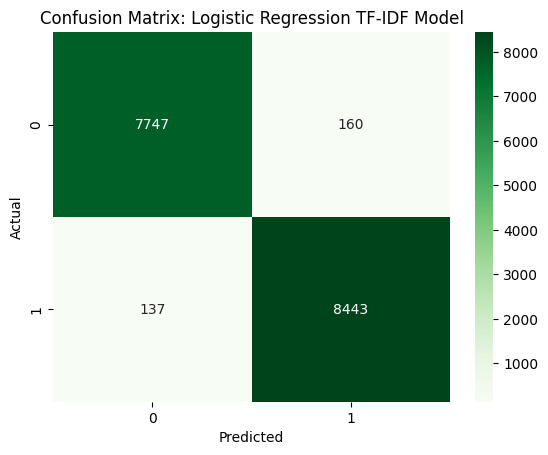

In [12]:
# 5. TF-IDF Feature Extraction
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)

# Logistic Regression Model
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, train_labels)
log_preds = log_model.predict(X_test)
print("\n=== Logistic Regression Evaluation (TF-IDF) ===")
print(classification_report(test_labels, log_preds))
joblib.dump(log_model, 'logistic_regression_model.pkl')

log_conf_matrix = confusion_matrix(test_labels, log_preds)
sns.heatmap(log_conf_matrix, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix: Logistic Regression TF-IDF Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('logreg_confusion_matrix.png')
plt.show()


=== Baseline Model Evaluation (TF-IDF + SVM) ===
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      7907
           1       0.98      0.99      0.99      8580

    accuracy                           0.98     16487
   macro avg       0.98      0.98      0.98     16487
weighted avg       0.98      0.98      0.98     16487



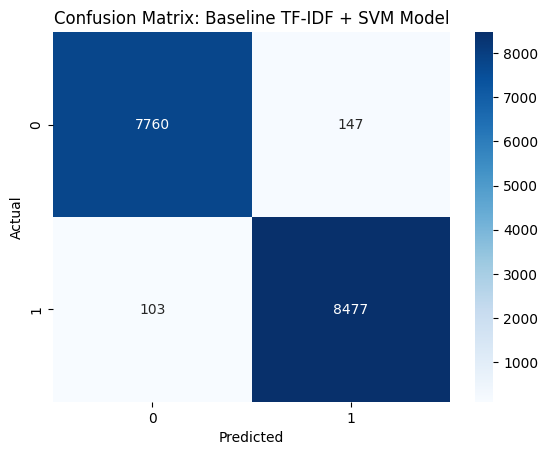

In [13]:
# Baseline Model: SVM
baseline_model = SVC(kernel='linear', probability=True)
baseline_model.fit(X_train, train_labels)
baseline_preds = baseline_model.predict(X_test)
print("\n=== Baseline Model Evaluation (TF-IDF + SVM) ===")
print(classification_report(test_labels, baseline_preds))
joblib.dump(baseline_model, 'baseline_svm_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

conf_matrix = confusion_matrix(test_labels, baseline_preds)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix: Baseline TF-IDF + SVM Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('baseline_confusion_matrix.png')
plt.show()

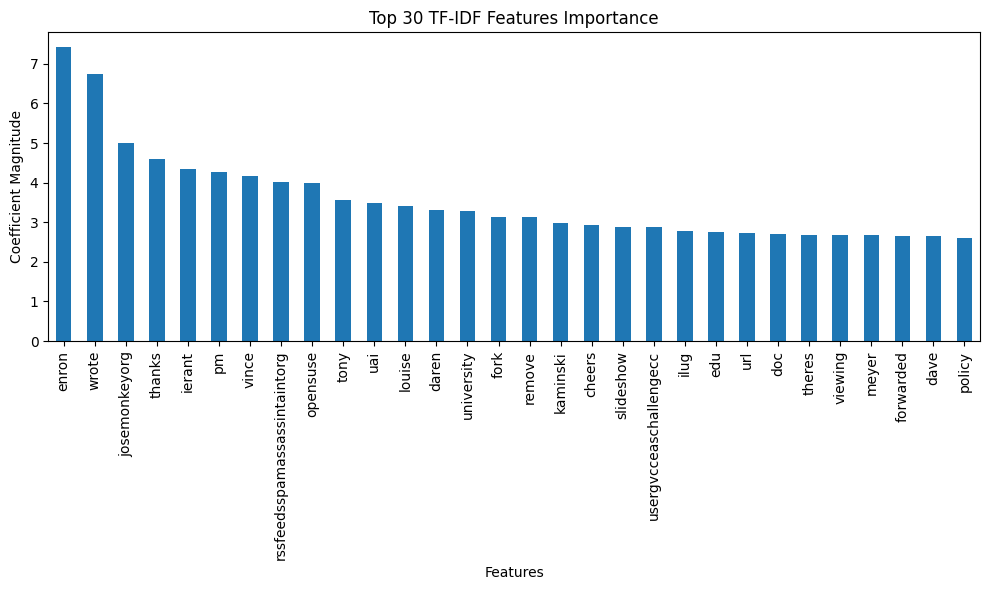

In [14]:
# TF-IDF Feature Importance
feature_names = vectorizer.get_feature_names_out()
coefficients = np.abs(baseline_model.coef_.toarray()[0])
feature_importance = pd.Series(coefficients, index=feature_names)
feature_importance = feature_importance.sort_values(ascending=False).head(30)

plt.figure(figsize=(10,6))
feature_importance.plot(kind='bar')
plt.title('Top 30 TF-IDF Features Importance')
plt.xlabel('Features')
plt.ylabel('Coefficient Magnitude')
plt.tight_layout()
plt.savefig('tfidf_feature_importance.png')
plt.show()

In [ ]:
# DistilBERT Section...

# Tokenization
train_texts = list(train_texts)
test_texts = list(test_texts)
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

# Dataset Class
class EmailDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = EmailDataset(train_encodings, train_labels)
test_dataset = EmailDataset(test_encodings, test_labels)

# Load Model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# Use GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Training Arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    # evaluation_strategy="epoch",
    logging_dir='./logs',
    logging_steps=10,
    # load_best_model_at_end=True,
    # report_to="none",
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Fine-tune DistilBERT
trainer.train()


In [16]:
# Evaluate DistilBERT
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)

print("=== DistilBERT Model Evaluation ===")
print(classification_report(test_labels, preds))

# Save DistilBERT model
model.save_pretrained('distilbert_phishing_model')
tokenizer.save_pretrained('distilbert_phishing_tokenizer')

=== DistilBERT Model Evaluation ===
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      7907
           1       1.00      1.00      1.00      8580

    accuracy                           1.00     16487
   macro avg       1.00      1.00      1.00     16487
weighted avg       1.00      1.00      1.00     16487



('distilbert_phishing_tokenizer/tokenizer_config.json',
 'distilbert_phishing_tokenizer/special_tokens_map.json',
 'distilbert_phishing_tokenizer/vocab.txt',
 'distilbert_phishing_tokenizer/added_tokens.json',
 'distilbert_phishing_tokenizer/tokenizer.json')

DistilBERT ROC-AUC: 0.9997183900370951


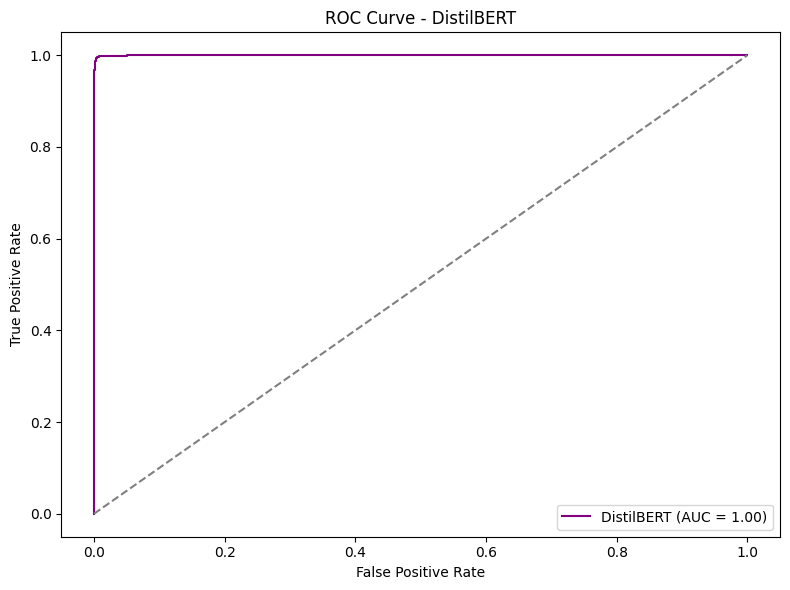

In [36]:
# ROC Curve for DistilBERT

from sklearn.metrics import roc_curve, roc_auc_score
bert_probs = predictions.predictions[:, 1]
print("DistilBERT ROC-AUC:", roc_auc_score(test_labels, bert_probs))


fpr, tpr, _ = roc_curve(test_labels, bert_probs)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='purple', label=f'DistilBERT (AUC = {roc_auc_score(test_labels, bert_probs):.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - DistilBERT')
plt.legend()
plt.tight_layout()
plt.savefig('distilbert_roc_curve.png')
plt.show()

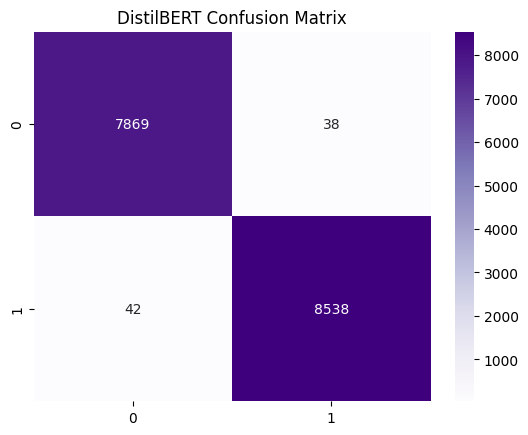

In [33]:
# Confusion Matrix
sns.heatmap(confusion_matrix(test_labels, preds), annot=True, fmt='d', cmap='Purples')
plt.title("DistilBERT Confusion Matrix")
plt.savefig("distilbert_confusion_matrix.png")
plt.show()

0.9819858069994541 0.9848365378783284 0.9951476921210651


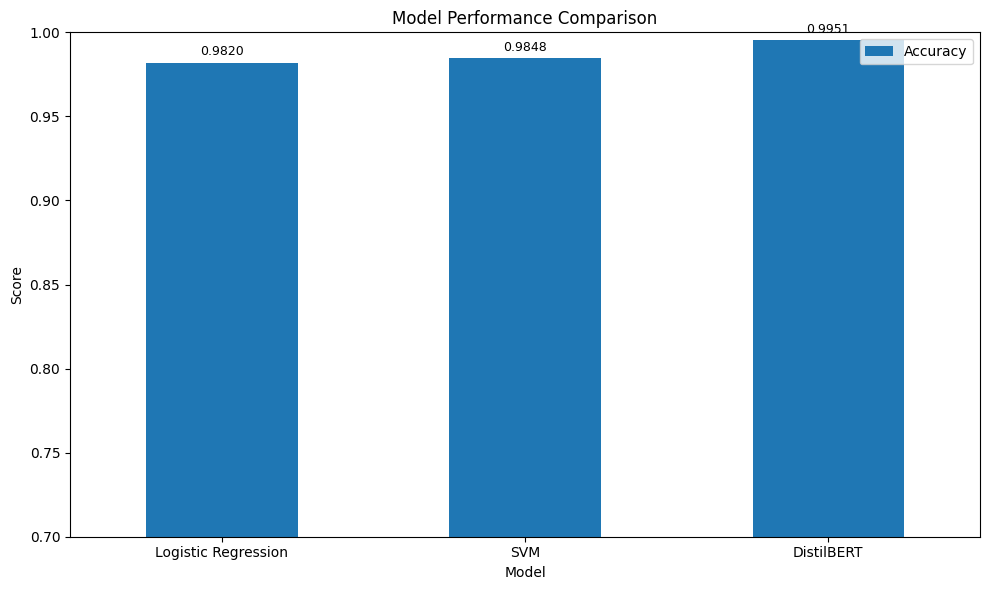

In [46]:
# Comparison Graph
log_accuracy = accuracy_score(test_labels, log_preds)
svm_accuracy = accuracy_score(test_labels, baseline_preds)
bert_accuracy = accuracy_score(test_labels, preds)
print(log_accuracy, svm_accuracy, bert_accuracy)
metrics_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'SVM', 'DistilBERT'],
    'Accuracy': [log_accuracy, svm_accuracy, bert_accuracy],
})

metrics_ax = metrics_df.set_index('Model').plot(kind='bar', figsize=(10,6))
for p in metrics_ax.patches:
    metrics_ax.annotate(f"{p.get_height():.4f}", (p.get_x() + p.get_width()/2., p.get_height()),
                        ha='center', va='bottom', fontsize=9, color='black', xytext=(0, 3),
                        textcoords='offset points')
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.ylim(0.7, 1.0)
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('model_comparison.png')
plt.show()

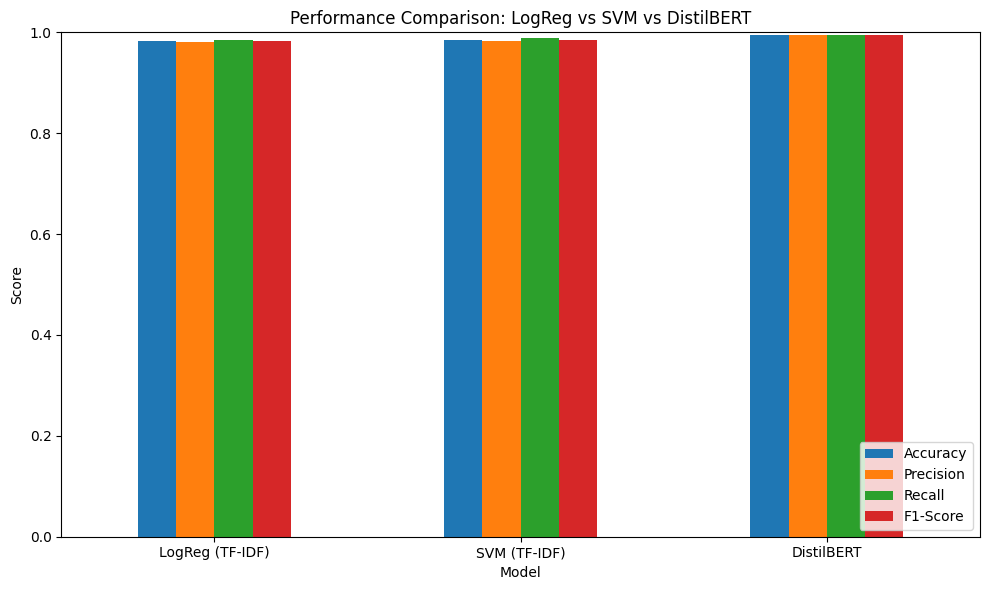

In [47]:
9# Final Comparison Graph: Logistic Regression vs SVM vs DistilBERT
log_accuracy = accuracy_score(test_labels, log_preds)
log_precision, log_recall, log_f1, _ = precision_recall_fscore_support(test_labels, log_preds, average='binary')

svm_accuracy = accuracy_score(test_labels, baseline_preds)
svm_precision, svm_recall, svm_f1, _ = precision_recall_fscore_support(test_labels, baseline_preds, average='binary')

distilbert_accuracy = accuracy_score(test_labels, preds)
distilbert_precision, distilbert_recall, distilbert_f1, _ = precision_recall_fscore_support(test_labels, preds, average='binary')

metrics_df = pd.DataFrame({
    'Model': ['LogReg (TF-IDF)', 'SVM (TF-IDF)', 'DistilBERT'],
    'Accuracy': [log_accuracy, svm_accuracy, distilbert_accuracy],
    'Precision': [log_precision, svm_precision, distilbert_precision],
    'Recall': [log_recall, svm_recall, distilbert_recall],
    'F1-Score': [log_f1, svm_f1, distilbert_f1]
})

metrics_df.set_index('Model').plot(kind='bar', figsize=(10,6))
plt.title('Performance Comparison: LogReg vs SVM vs DistilBERT')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('final_model_comparison.png')
plt.show()

In [48]:

# === Sample Email Testing ===

sample_emails = [
    "Please confirm your account by clicking the link below. Your password has been compromised.",
    "Meeting rescheduled to 3PM tomorrow. Let me know if you have any conflicts.",
    "Urgent: Your bank account has been locked. Visit our site to verify your credentials."
]

# Preprocess
sample_cleaned = [clean_email_body(email) for email in sample_emails]

# TF-IDF predictions
sample_vectorized = vectorizer.transform(sample_cleaned)
print("TF-IDF + Logistic Regression Predictions:", log_model.predict(sample_vectorized))
print("TF-IDF + SVM Predictions:", baseline_model.predict(sample_vectorized))

# DistilBERT predictions
sample_tokens = tokenizer(sample_emails, truncation=True, padding=True, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**sample_tokens)
    distil_preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
print("DistilBERT Predictions:", distil_preds)


TF-IDF + Logistic Regression Predictions: [1 0 1]
TF-IDF + SVM Predictions: [1 0 1]
DistilBERT Predictions: [1 0 1]


In [50]:
# Add challenging email
challenging_email = ["Hope you’re well. We updated our internal portal. Use your login to access benefits. Let us know if issues arise."]
cleaned = [clean_email_body(challenging_email[0])]

# TF-IDF SVM Prediction
tfidf_vector = vectorizer.transform(cleaned)
print("SVM Prediction:", baseline_model.predict(tfidf_vector)[0])  # 0 or 1

# DistilBERT Prediction
tokenized = tokenizer(challenging_email, truncation=True, padding=True, return_tensors="pt").to(device)
with torch.no_grad():
    output = model(**tokenized)
    distilbert_pred = torch.argmax(output.logits, dim=1).item()
print("DistilBERT Prediction:", distilbert_pred)


SVM Prediction: 0
DistilBERT Prediction: 1


In [51]:
# === Save All Outputs to Zip ===
import zipfile, os

files_to_zip = [
    'logistic_regression_model.pkl',
    'baseline_svm_model.pkl',
    'tfidf_vectorizer.pkl',
    'label_distribution_before_sampling.png',
    'label_distribution_after_sampling.png',
    'logreg_confusion_matrix.png',
    'baseline_confusion_matrix.png',
    'tfidf_feature_importance.png',
    'distilbert_confusion_matrix.png',
    'distilbert_roc_curve.png',
    'model_comparison.png'
]

with zipfile.ZipFile('phishing_model_outputs.zip', 'w') as zipf:
    for file in files_to_zip:
        if os.path.exists(file):
            zipf.write(file)
print("Saved all models and outputs to phishing_model_outputs.zip")

Saved all models and outputs to phishing_model_outputs.zip
